In [42]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
#export
from fastml.model.model import *
from fastml.model.callbacks import *
from fastml.examples import examples
from functools import partial
from fastml.model.callbacks import view_tfm

In [44]:
#export
def flatten(x): return x.view(x.shape[0], -1)

def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [45]:
mnist_data.train_ds.x[0].shape, mnist_resize(mnist_data.train_ds.x[0]).shape, flatten(mnist_resize(mnist_data.train_ds.x[0])).shape

(torch.Size([784]), torch.Size([1, 1, 28, 28]), torch.Size([1, 784]))

In [46]:
#export
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [47]:
model = get_cnn_model(mnist_data);
learner =  Learner(model, optimizers.SGD(model, lr=0.4), loss.cross_entropy(), mnist_data)
cb_funcs=[Recorder, partial(AvgStatsCallback, metrics.accuracy)]
run = Runner(cb_funcs=cb_funcs)

%time run.fit(2, learner)

train: [0.4679850390625, 84.146]
valid: [0.11841800537109375, 96.49]
train: [0.090148271484375, 97.07]
valid: [0.07939843139648438, 97.51]
CPU times: user 14 s, sys: 980 ms, total: 15 s
Wall time: 15.2 s


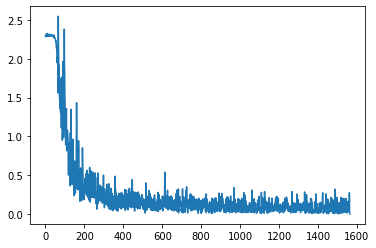

In [48]:
run.recorder.plot_loss()

In [53]:
#export
def conv2d(in_channels, out_channels, kernel_size=3, stride=2, act_func=nn.ReLU()):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2, stride=stride), nn.ReLU())

In [54]:
#export
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

mnist_view = view_tfm(1,28,28)

In [55]:
cb_funcs=[Recorder, partial(AvgStatsCallback, metrics.accuracy), partial(BatchTransformXCallback, mnist_view)]
model = get_cnn_model(mnist_data, [8,16,32,32])

run = Runner(cb_funcs=cb_funcs)
%time run.fit(2, learner)

train: [0.047201396484375, 98.486]
valid: [0.061937579345703125, 98.31]
train: [0.041558466796875, 98.69]
valid: [0.051968426513671874, 98.54]
CPU times: user 14.9 s, sys: 1.18 s, total: 16.1 s
Wall time: 16.7 s


## Export

In [52]:
!python notebook2script.py cnn_dev.ipynb fastml/model/image/cnn.py

Converted cnn_dev.ipynb to fastml/model/image/cnn.py
